# Multi-armed Bandit Problem

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class MultiArmedBandit:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.normal(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]

    def play(self, arm: int) -> float:
        mean = self.means[arm]
        return np.random.normal(mean, 1)
    


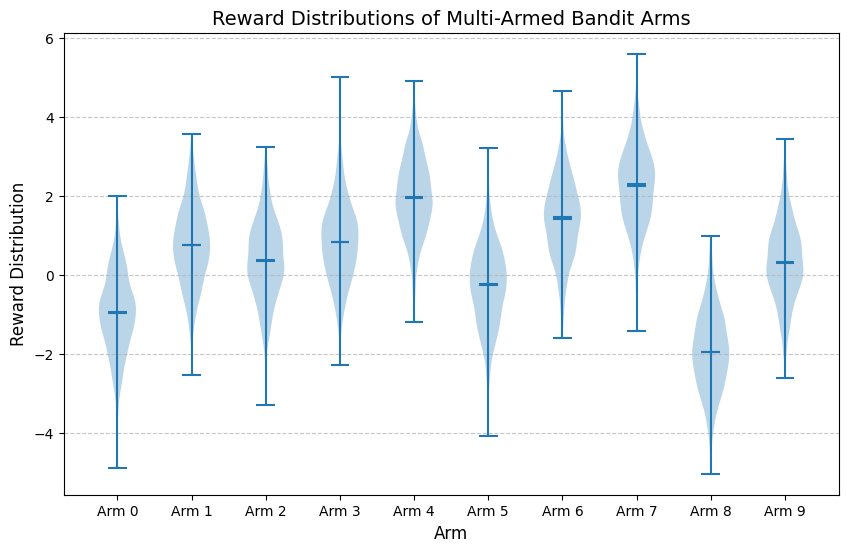

In [3]:
def plot_bandit(bandit: MultiArmedBandit):
    # Simulate rewards for each arm to create a distribution
    rewards = []
    for arm in range(bandit.number_of_arms):
        simulated_rewards = [bandit.play(arm) for _ in range(1000)]  # Simulate 1000 plays per arm
        rewards.append(simulated_rewards)
    
    plt.figure(figsize=(10, 6))
    plt.violinplot(rewards, showmeans=True, showmedians=True)
    plt.xlabel("Arm", fontsize=12)
    plt.ylabel("Reward Distribution", fontsize=12)
    plt.title("Reward Distributions of Multi-Armed Bandit Arms", fontsize=14)
    plt.xticks(range(1, bandit.number_of_arms + 1), [f'Arm {i}' for i in range(bandit.number_of_arms)], fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a MultiArmedBandit instance and plot using a violin plot
bandit = MultiArmedBandit(10)
plot_bandit(bandit)

In [4]:
# random agent for a baseline
class RandomAgent:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms

    def choose_action(self) -> int:
        return random.randint(0, self.number_of_arms - 1)
    
    def update(self, arm: int, reward: float) -> None:
        pass
    

In [5]:
def run_and_collect_data(agent, bandit, num_steps):
    rewards = []
    best_action_counts = []
    regrets = []
    for _ in range(num_steps):
        action = agent.choose_action()
        reward = bandit.play(action)
        rewards.append(reward)
        best_action_counts.append(action == bandit.optimal_arm)
        regrets.append(bandit.optimal_mean - bandit.means[action])
        agent.update(action, reward)
    return rewards, best_action_counts, regrets


In [6]:
# Function to run the bandit problem for multiple agents and plot the results
def run_and_plot_for_agents(agents, agent_names, bandit, num_steps):
    # Initialize storage for results
    all_rewards = []
    all_best_action_counts = []
    all_regrets = []

    # Run the simulation for each agent
    for agent in agents:
        rewards, best_action_counts, regrets = run_and_collect_data(agent, bandit, num_steps)
        all_rewards.append(rewards)
        all_best_action_counts.append(best_action_counts)
        all_regrets.append(regrets)
    
    # Calculate average results across all agents
    average_rewards = [np.cumsum(rewards) / (np.arange(len(rewards)) + 1) for rewards in all_rewards]
    average_best_action_counts = [np.cumsum(best_action_counts) / (np.arange(len(best_action_counts)) + 1) for best_action_counts in all_best_action_counts]
    cumulative_regrets = [np.cumsum(regrets) for regrets in all_regrets]
    
    # Plot the results
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    
    for i, (agent, name) in enumerate(zip(agents, agent_names)):
        ax[0].plot(average_rewards[i], label=f'{name}')
        ax[1].plot(average_best_action_counts[i], label=f'{name}')
        ax[2].plot(cumulative_regrets[i], label=f'{name}')
    
    # Customize plots
    ax[0].set_xlabel('Steps', fontsize=12)
    ax[0].set_ylabel('Average Reward', fontsize=12)
    ax[0].set_title('Average Reward vs Steps', fontsize=14)
    ax[0].grid(linestyle='--', alpha=0.7)
    ax[0].legend()

    ax[1].set_xlabel('Steps', fontsize=12)
    ax[1].set_ylabel('Best Action Count', fontsize=12)
    ax[1].set_title('Best Action Count vs Steps', fontsize=14)
    ax[1].grid(linestyle='--', alpha=0.7)
    ax[1].legend()

    ax[2].set_xlabel('Steps', fontsize=12)
    ax[2].set_ylabel('Regret', fontsize=12)
    ax[2].set_title('Regret vs Steps', fontsize=14)
    ax[2].grid(linestyle='--', alpha=0.7)
    ax[2].legend()

    plt.tight_layout()
    plt.show()


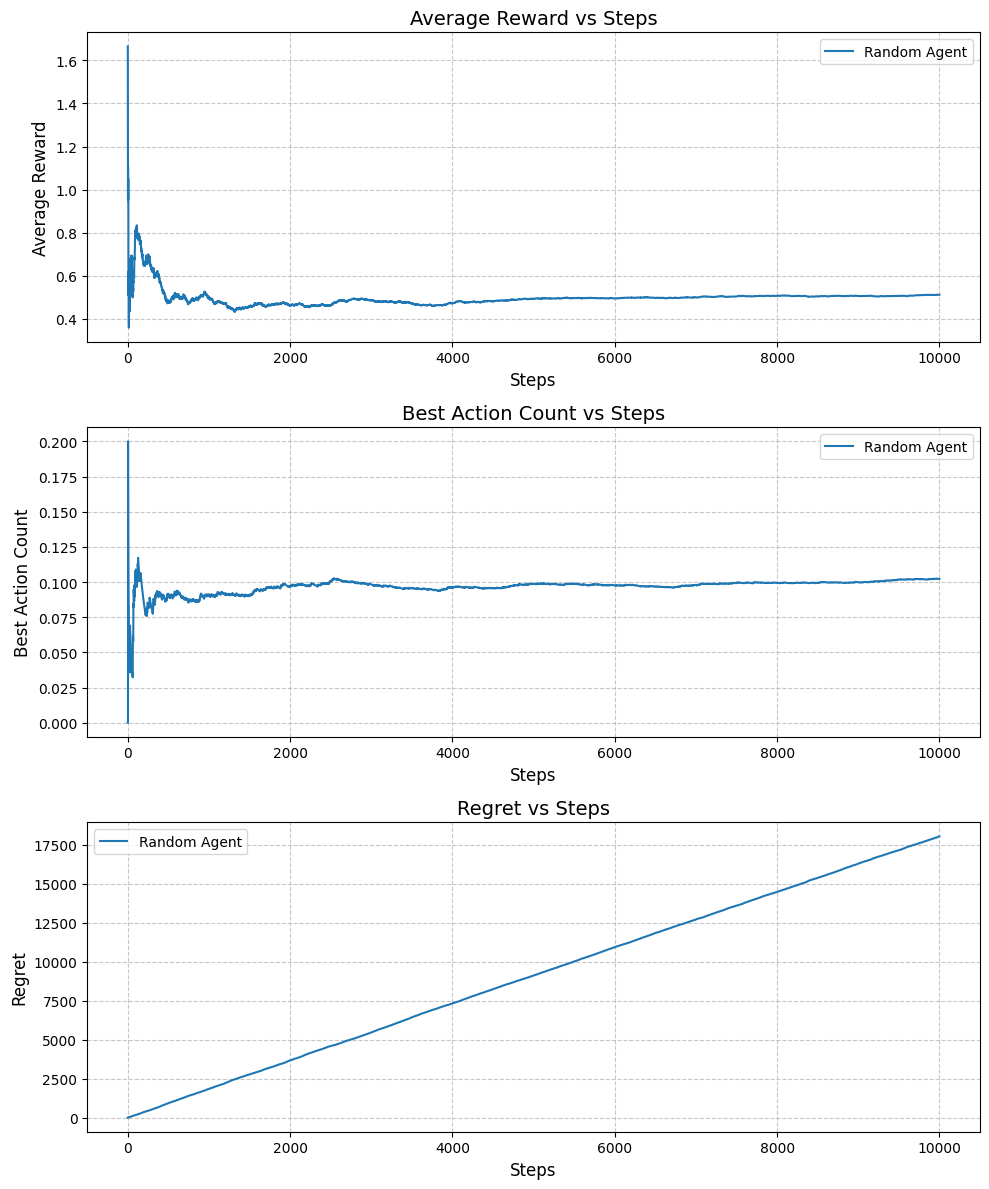

In [7]:
random_agent = RandomAgent(bandit)
agents = [random_agent]
agent_names = ['Random Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

# Explore-Then-Exploit

In [8]:
# a agent that explore every arm N times and then exploit the best arm
class ExploreThenExploit:
    def __init__(self, bandit: MultiArmedBandit, N: int) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms
        self.N = N
        self.action_count = np.zeros(self.number_of_arms)
        self.estimated_means = np.zeros(self.number_of_arms)
        self.stop_exploring = False

    def choose_action(self) -> int:
        if np.any(self.action_count < self.N):
            return np.argmin(self.action_count)
        else:
            self.stop_exploring = True
            return np.argmax(self.estimated_means)
        
    def update(self, arm: int, reward: float) -> None:
        if self.stop_exploring:
            return
        self.action_count[arm] += 1
        self.estimated_means[arm] += (reward - self.estimated_means[arm]) / self.action_count[arm]
        


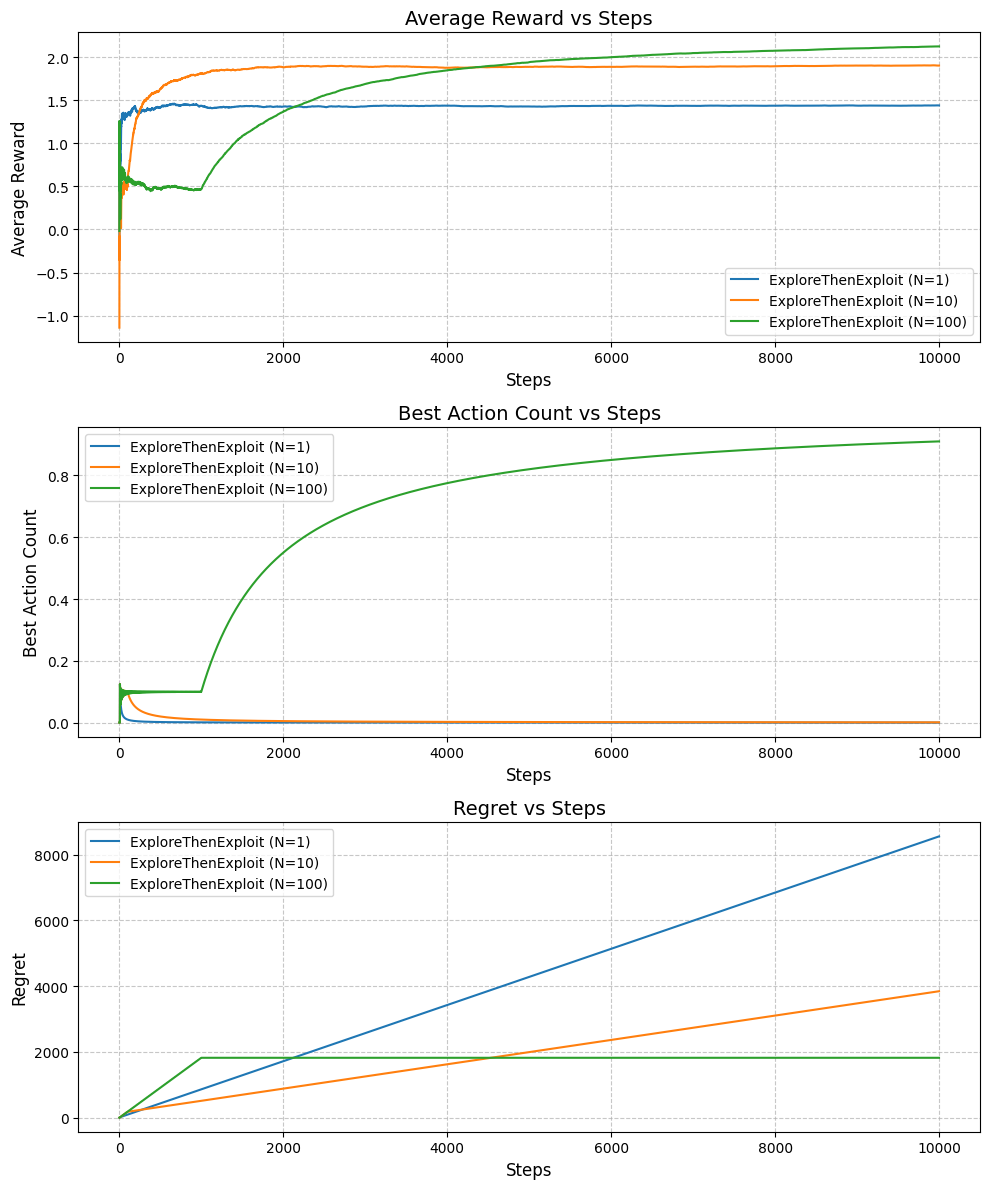

In [9]:
# run ExploreThenExploit agent for different values of N
agents = [ExploreThenExploit(bandit, N) for N in [1, 10, 100]]
agent_names = ['ExploreThenExploit (N=1)', 'ExploreThenExploit (N=10)', 'ExploreThenExploit (N=100)']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Epsilon-Greedy

In [10]:
class EpsilonGreedy:
    def __init__(self, bandit: MultiArmedBandit, epsilon: float=0.1) -> None:
        self.bandit = bandit
        self.epsilon = epsilon
        self.number_of_arms = bandit.number_of_arms
        self.estimated_means = np.zeros(self.number_of_arms)
        self.action_counts = np.zeros(self.number_of_arms)

    def choose_action(self) -> int:
        if random.random() < self.epsilon:
            return random.randint(0, self.number_of_arms - 1)
        else:
            return np.argmax(self.estimated_means)

    def update(self, action: int, reward: float) -> None:
        self.action_counts[action] += 1
        self.estimated_means[action] += (reward - self.estimated_means[action]) / self.action_counts[action]

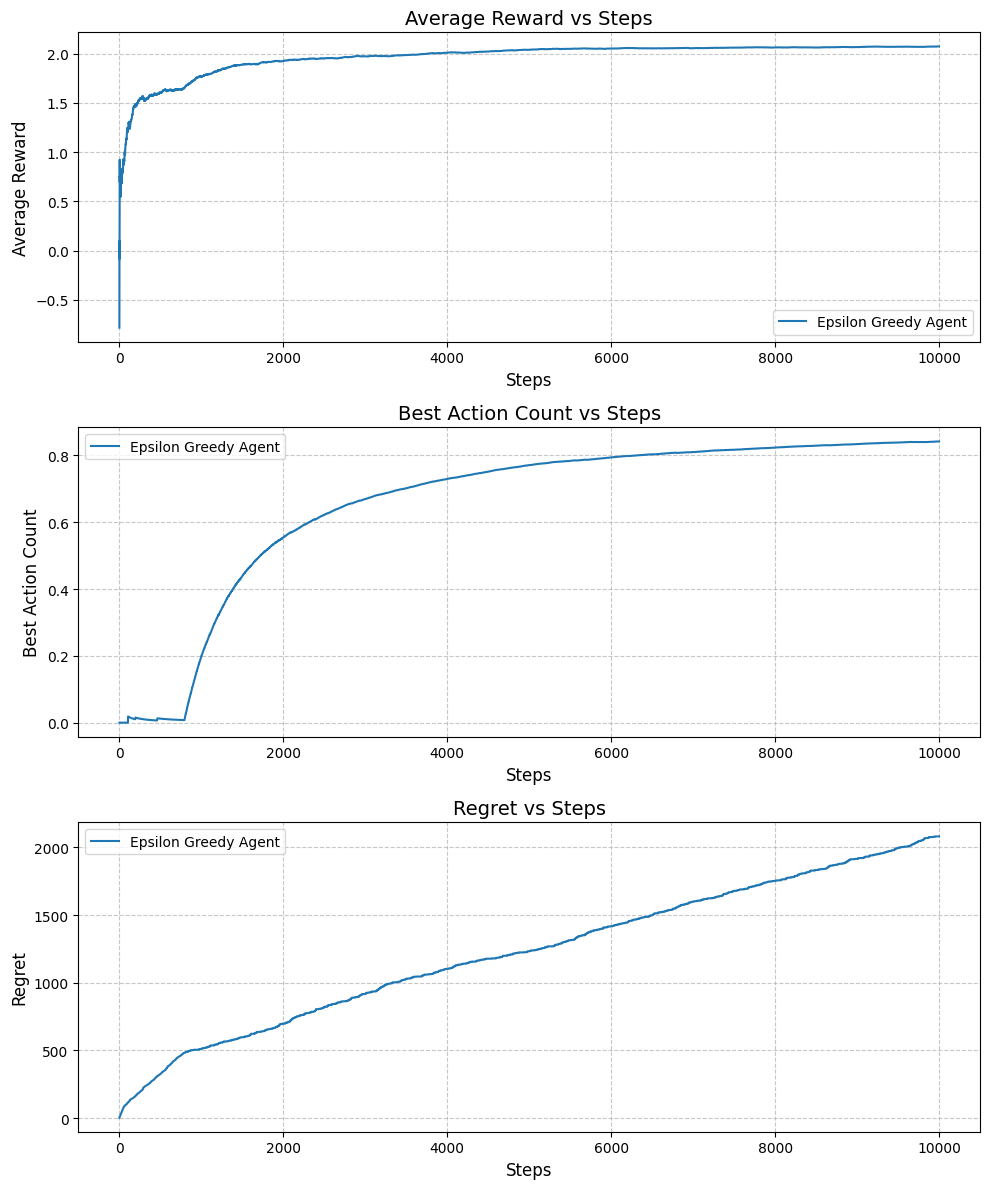

In [11]:
# Run the epsilon-greedy agent and plot the results
epsilon_greedy_agent = EpsilonGreedy(bandit, epsilon=0.1)
agents = [epsilon_greedy_agent]
agent_names = ['Epsilon Greedy Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Upper Confidence Bounds (UCB algorithm)

In [12]:
class UCB:
    def __init__(self, bandit: MultiArmedBandit, c: float=2) -> None:
        self.bandit = bandit
        self.c = c
        self.number_of_arms = bandit.number_of_arms
        self.estimated_means = np.zeros(self.number_of_arms)
        self.action_counts = np.zeros(self.number_of_arms)
        self.time_step = 0

    def choose_action(self) -> int:
        self.time_step += 1
        ucb_values = self.estimated_means + self.c * np.sqrt(np.log(self.time_step) / (self.action_counts + 1e-7))
        return np.argmax(ucb_values)

    def update(self, action: int, reward: float) -> None:
        self.action_counts[action] += 1
        self.estimated_means[action] += (reward - self.estimated_means[action]) / self.action_counts[action]

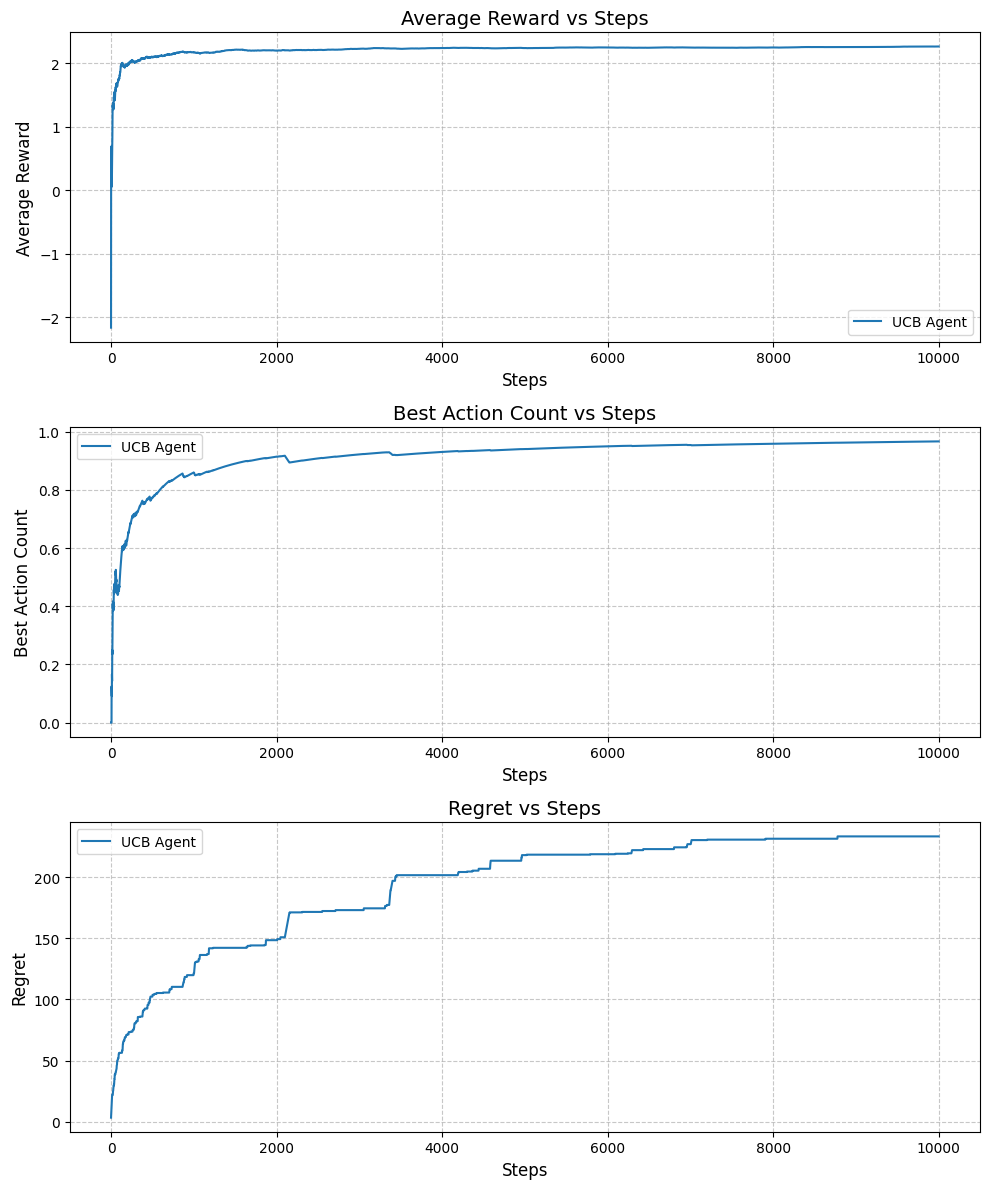

In [13]:
ucb_agent = UCB(bandit, c=2)
agents = [ucb_agent]
agent_names = ['UCB Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Epsilon-greedy versus UCB

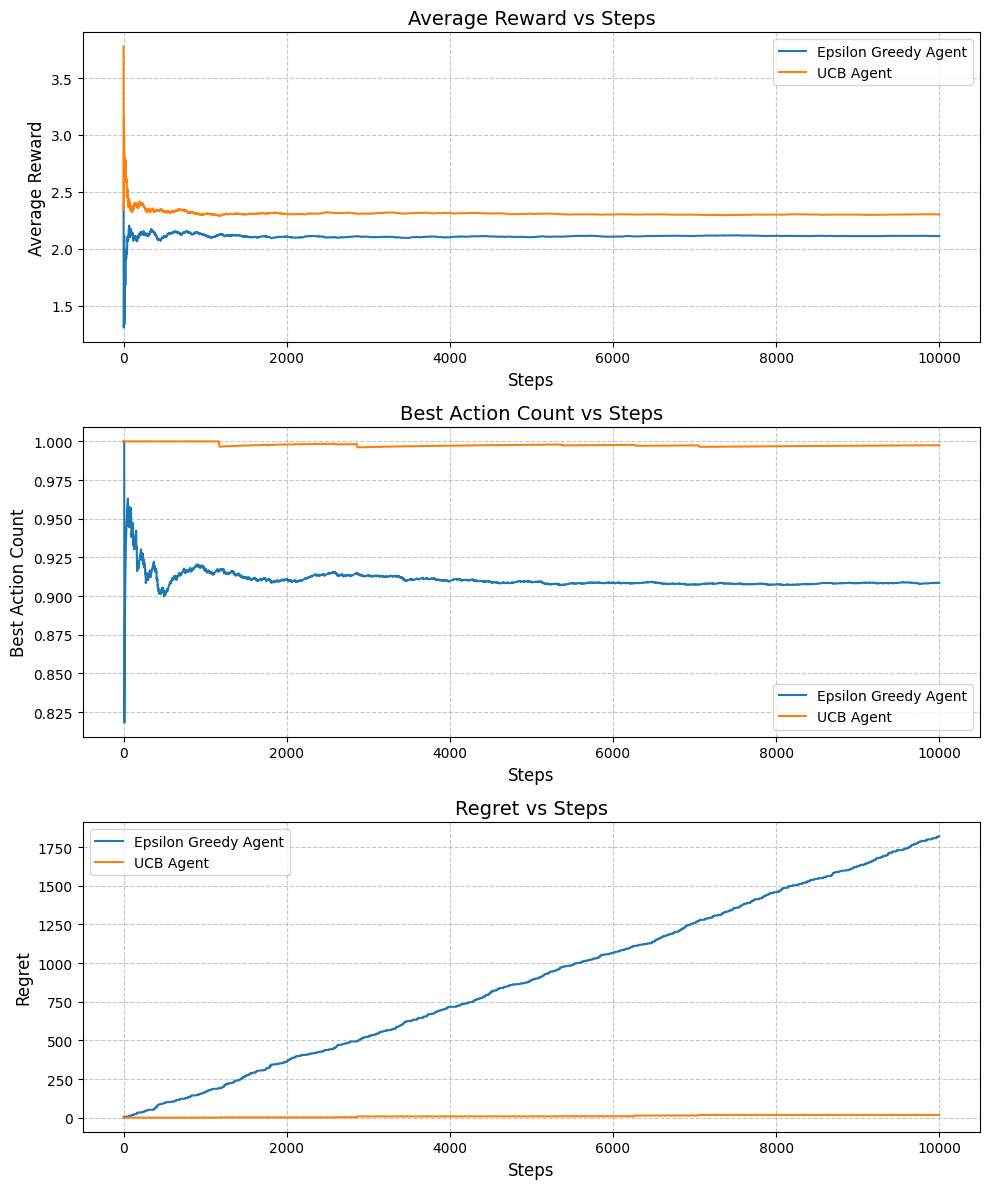

In [14]:
# run the epsilon greedy and UCB agents together
agents = [epsilon_greedy_agent, ucb_agent]
agent_names = ['Epsilon Greedy Agent', 'UCB Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

# Influence of epsilon in epsilon-greedy

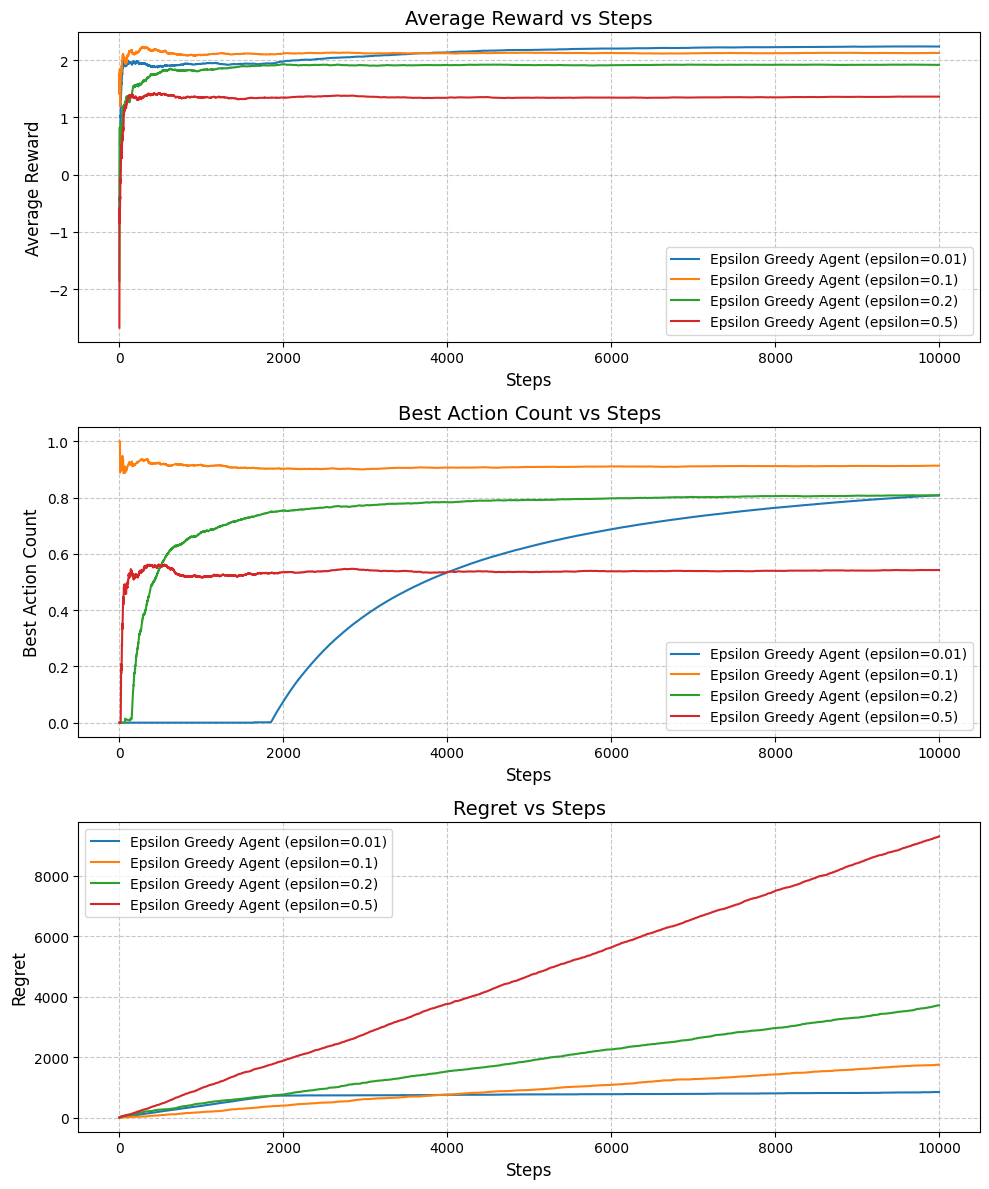

In [15]:
# run epsilon greedy for different values of epsilon
epsilons = [0.01, 0.1, 0.2, 0.5]
epsilon_agents = [EpsilonGreedy(bandit, epsilon) for epsilon in epsilons]
agent_names = [f'Epsilon Greedy Agent (epsilon={epsilon})' for epsilon in epsilons]
run_and_plot_for_agents(epsilon_agents, agent_names, bandit, 10000)

# Influence of c in UCB

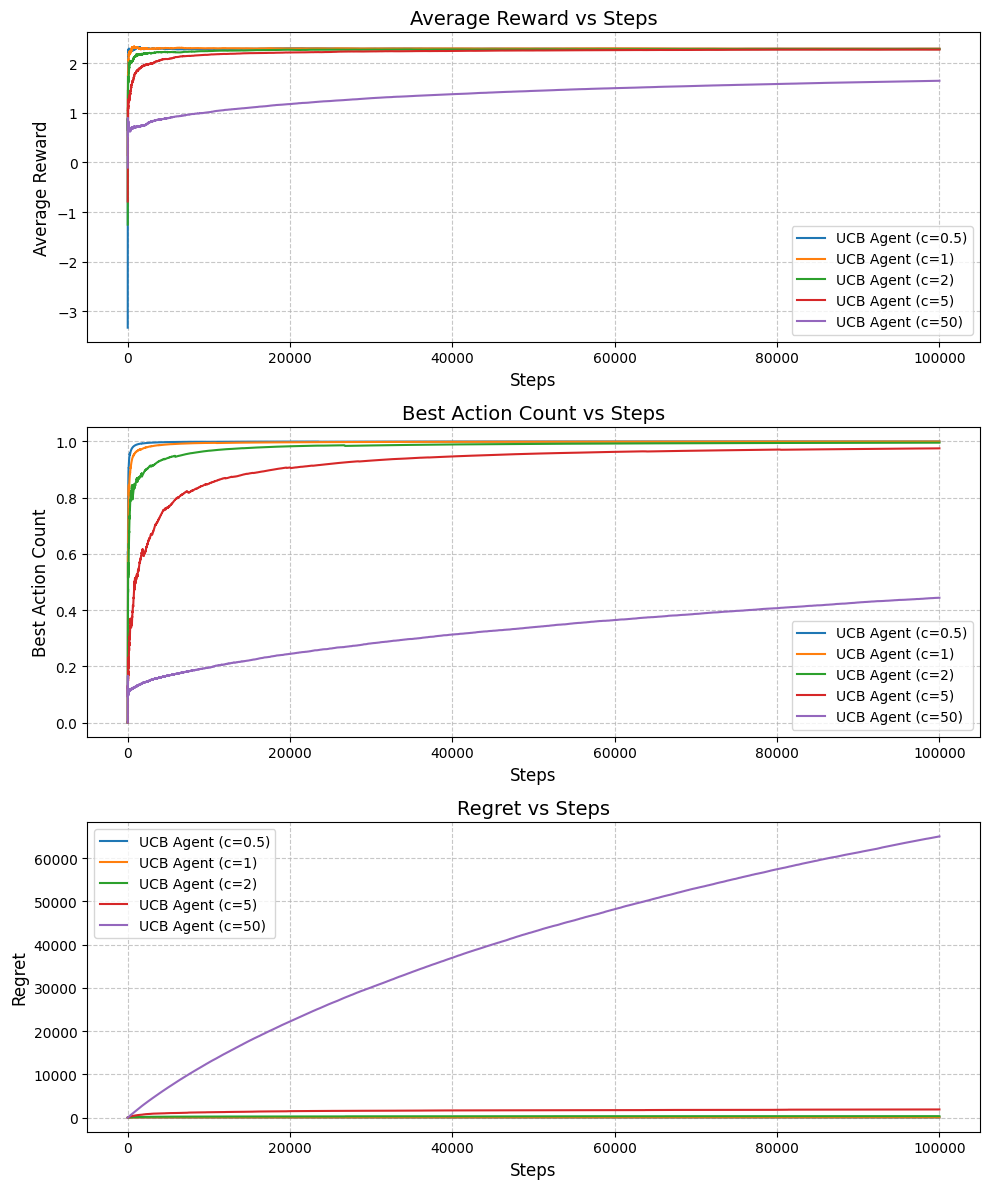

In [16]:
cs = [0.5, 1, 2, 5, 50]
ucb_agents = [UCB(bandit, c) for c in cs]
agent_names = [f'UCB Agent (c={c})' for c in cs]
run_and_plot_for_agents(ucb_agents, agent_names, bandit, 100000)

# Visualization of UCB algorithm

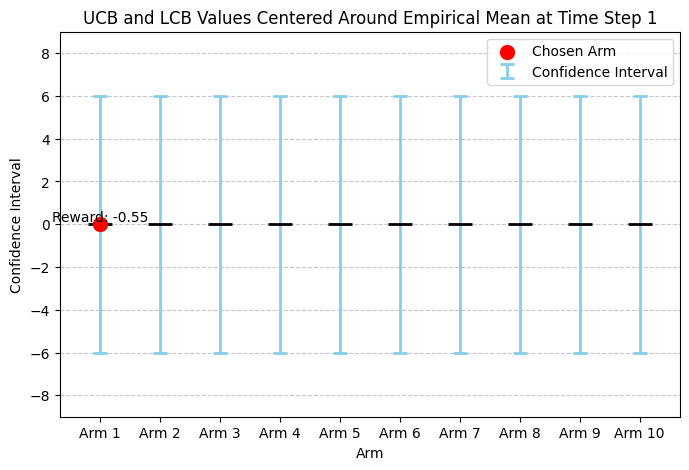

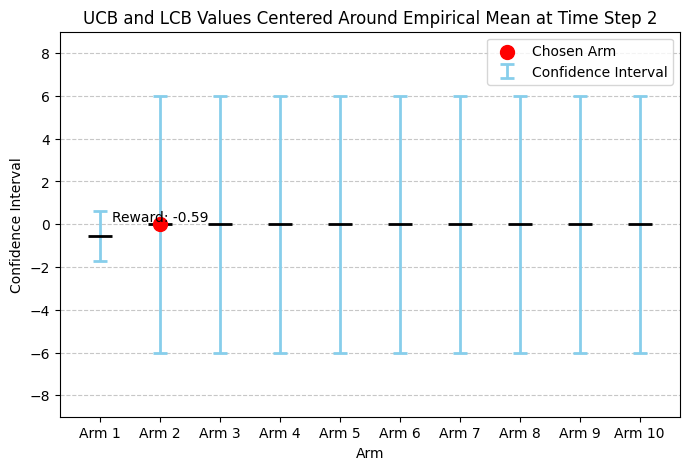

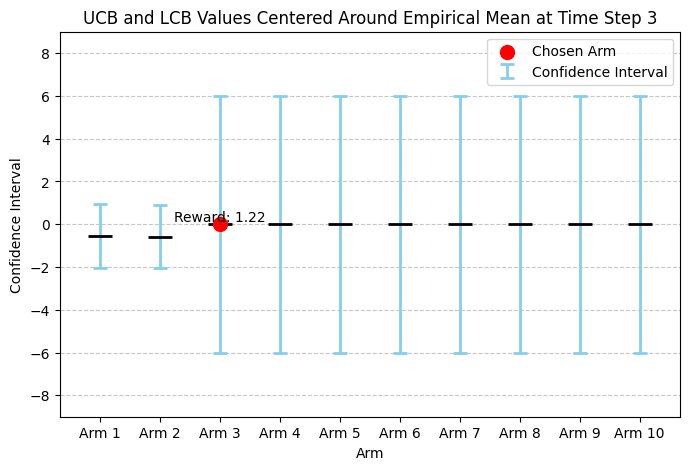

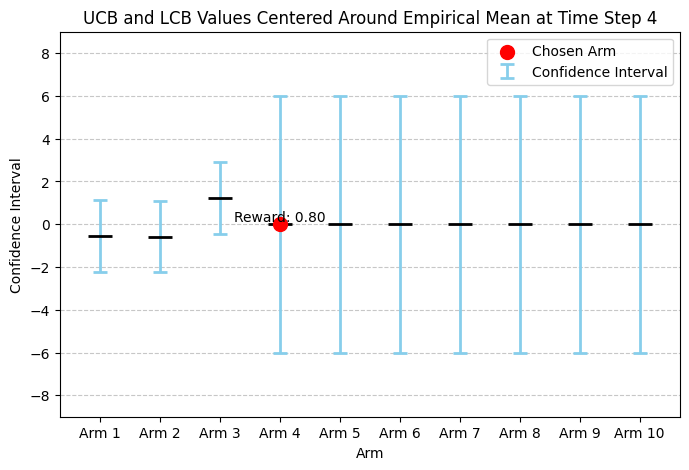

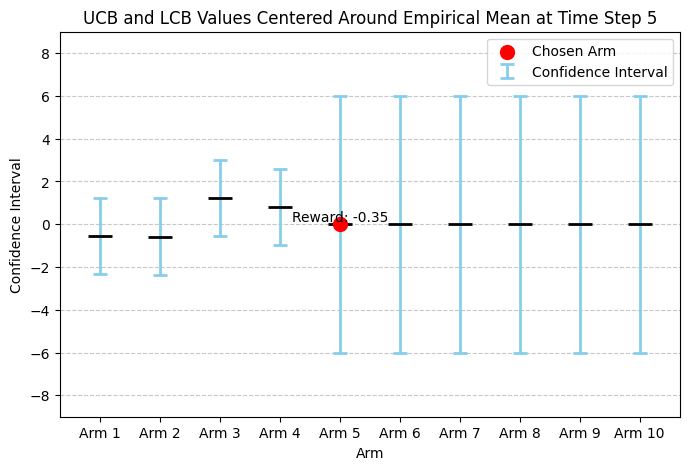

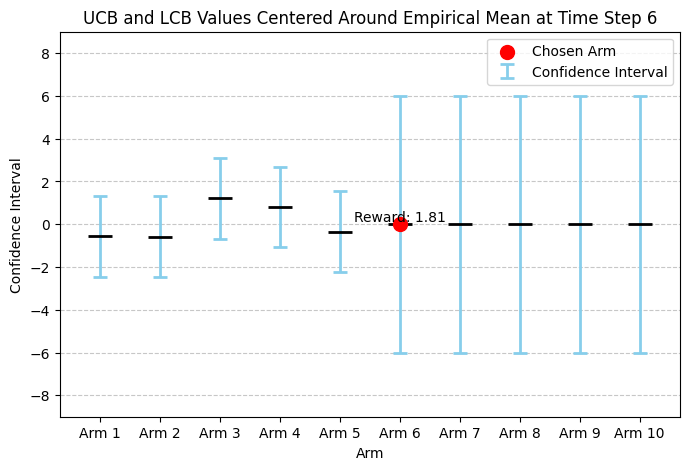

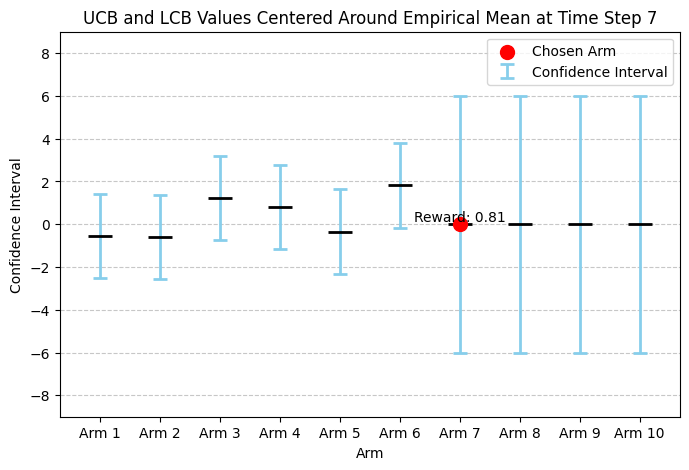

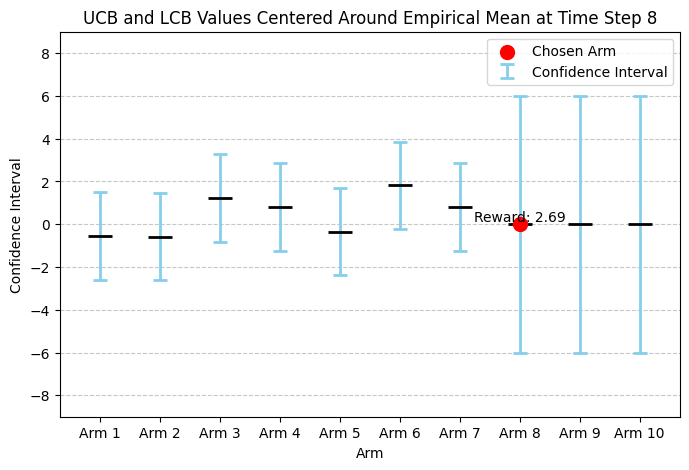

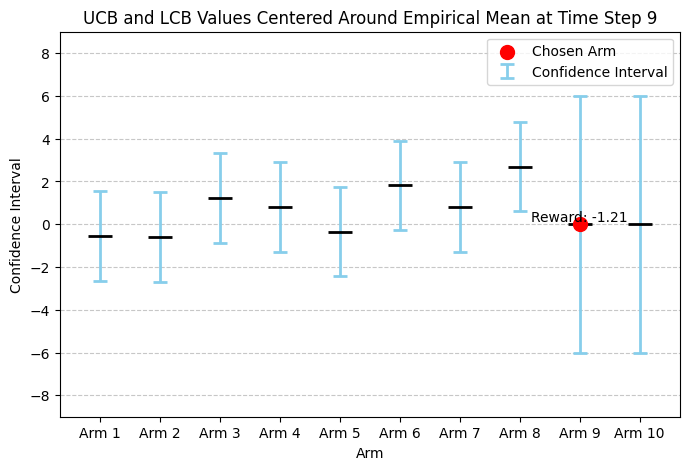

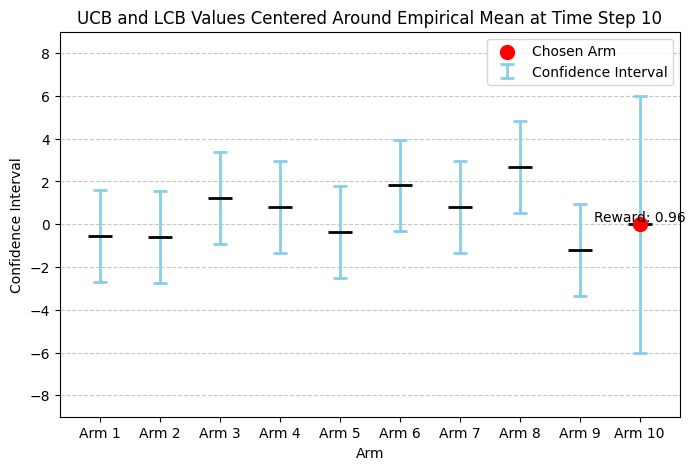

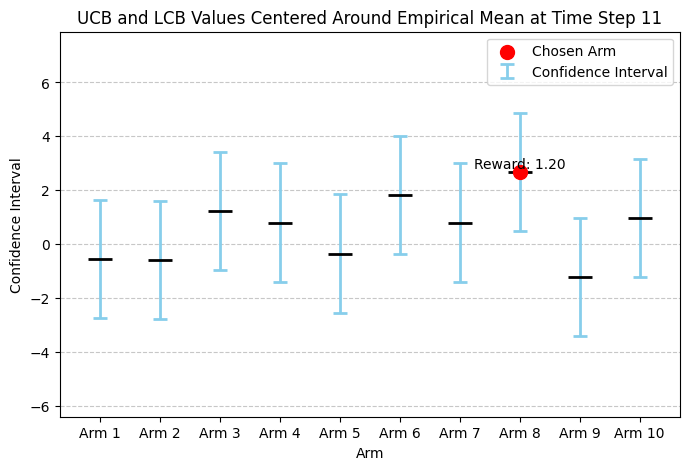

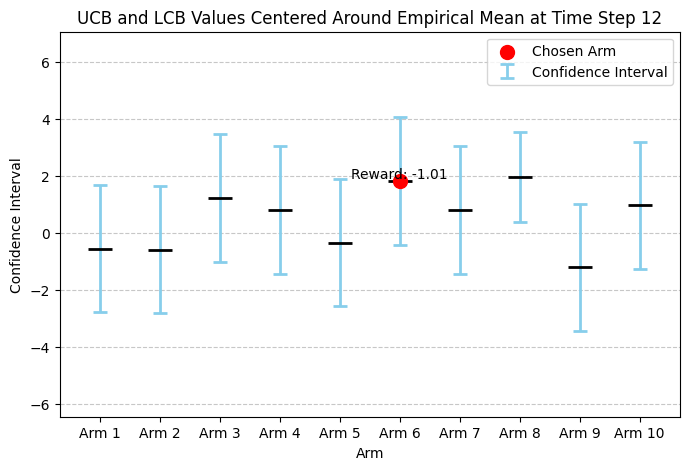

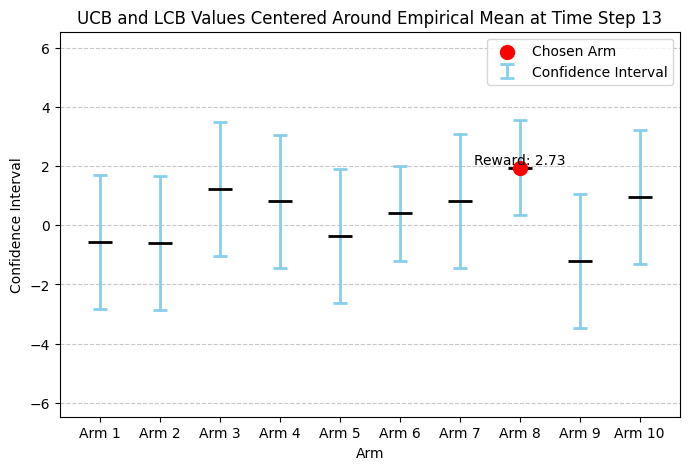

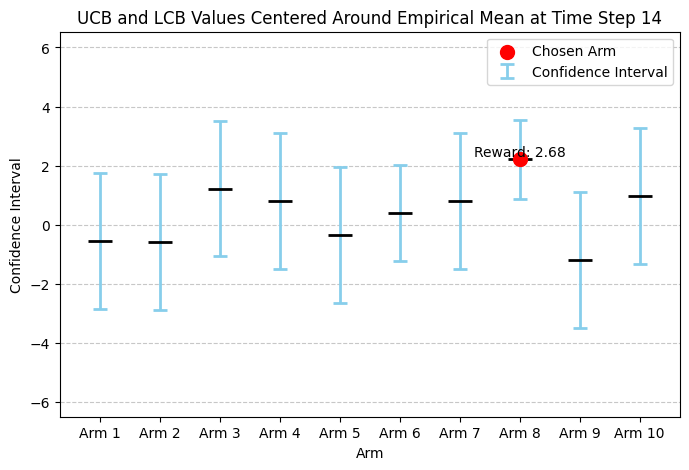

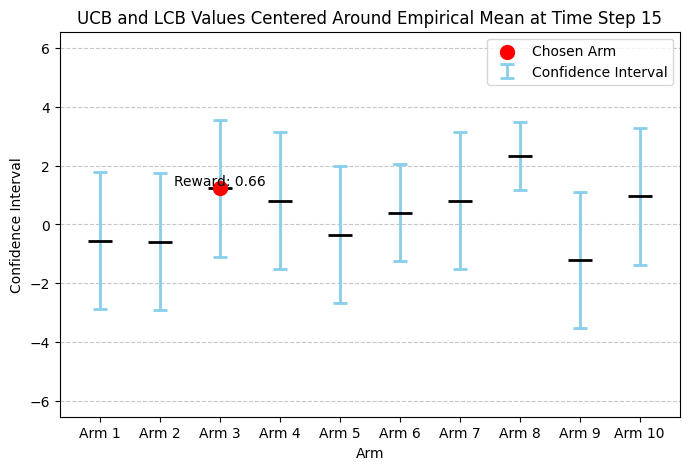

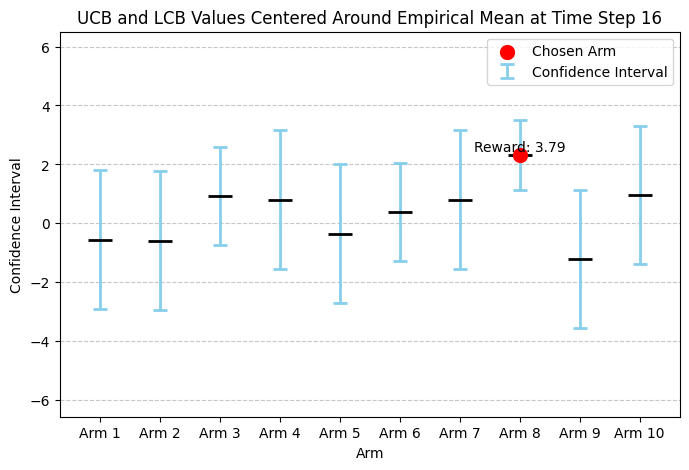

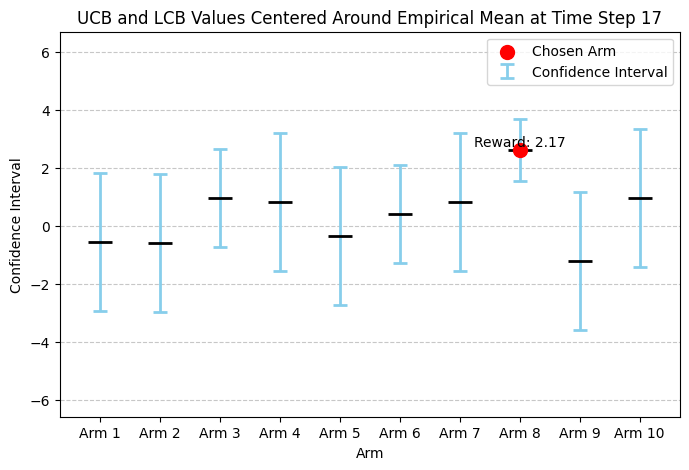

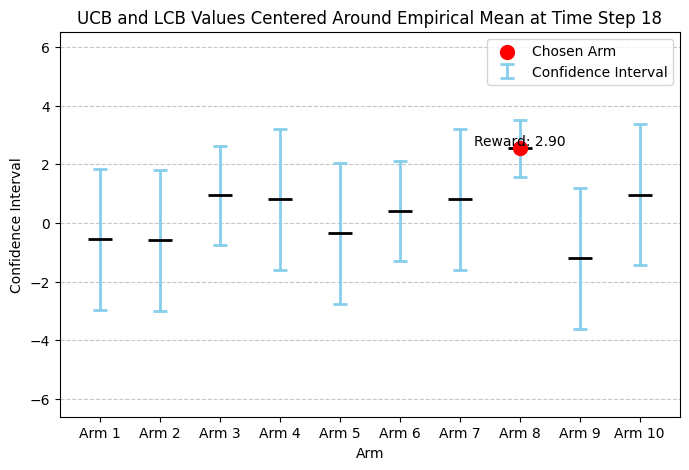

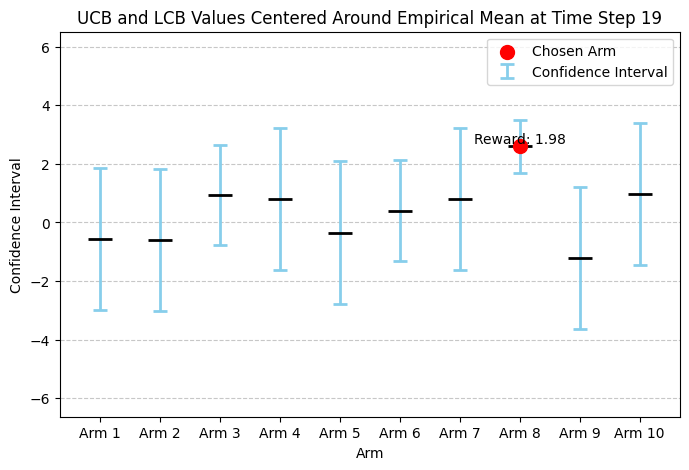

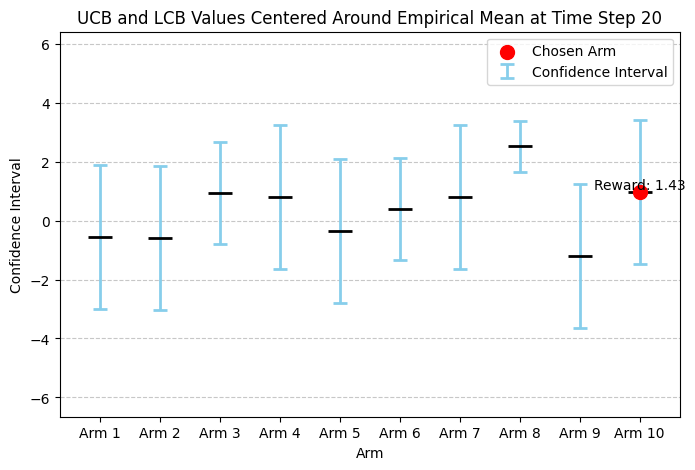

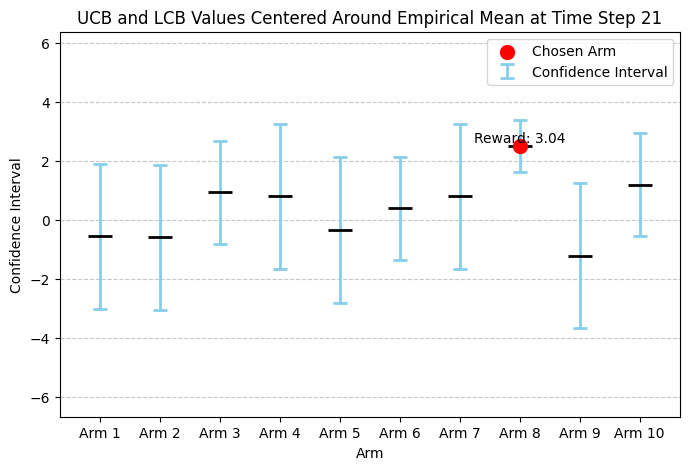

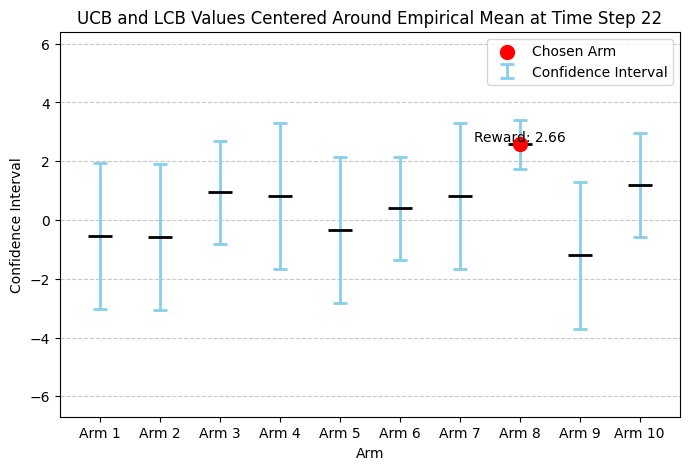

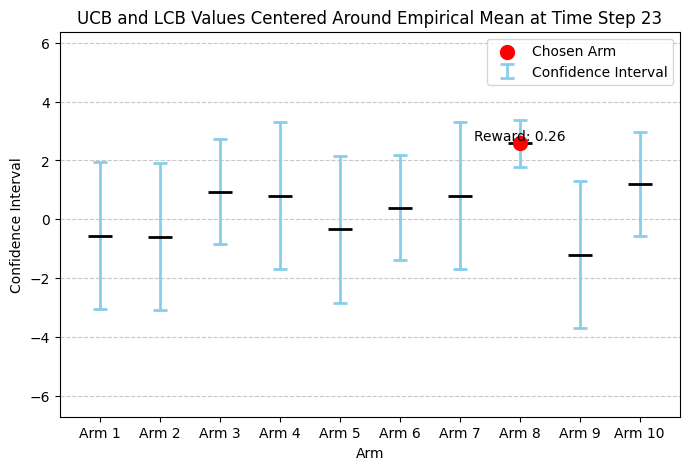

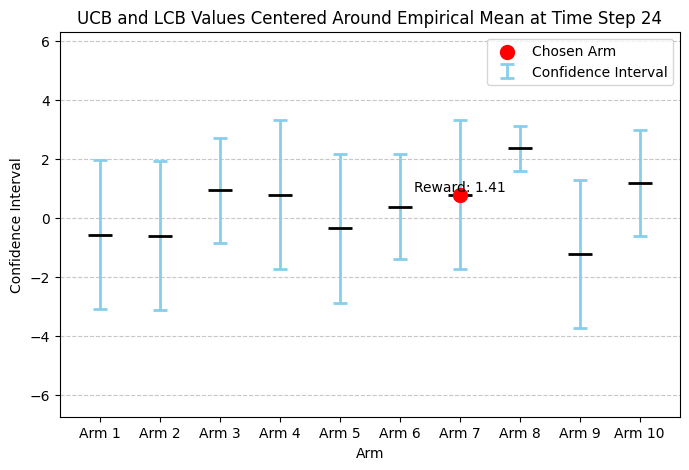

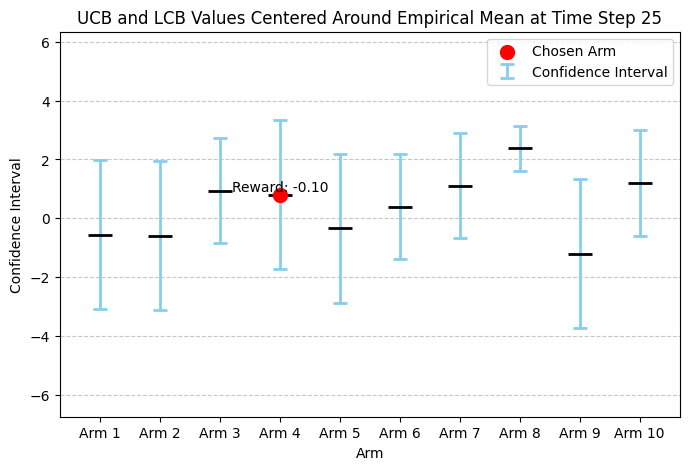

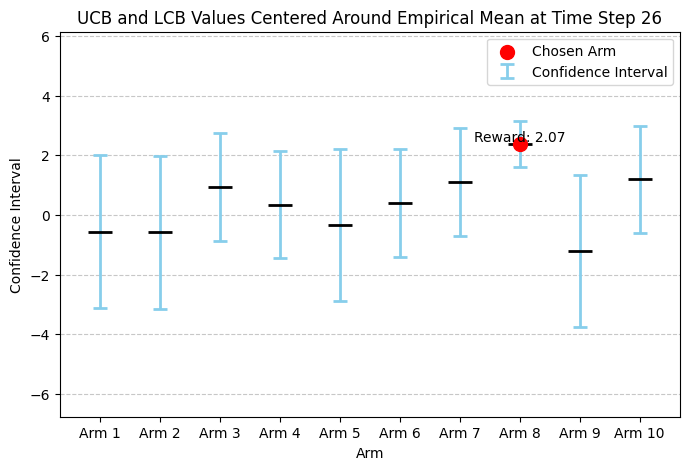

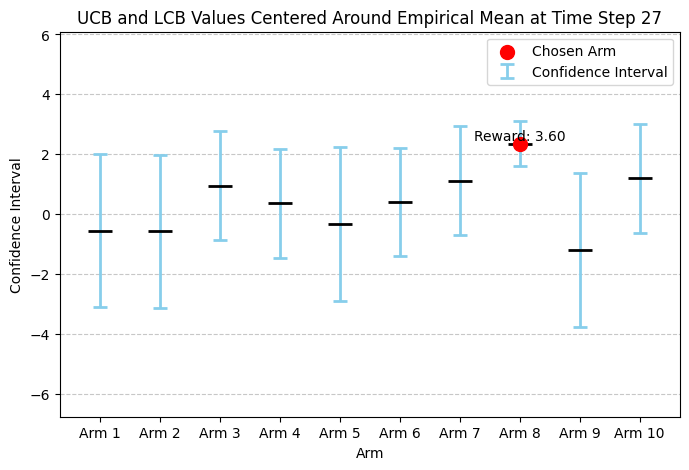

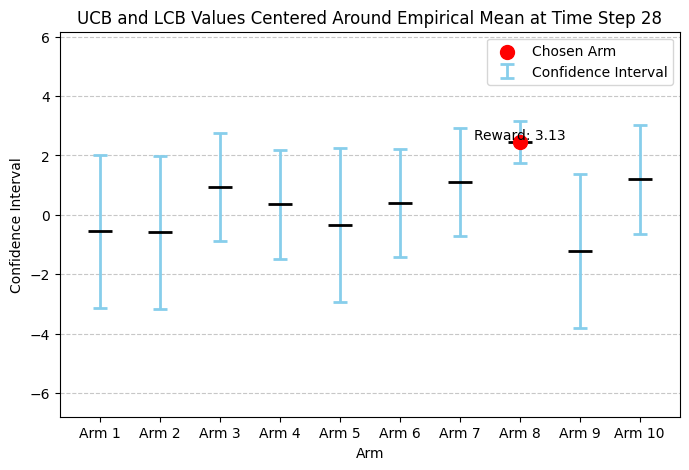

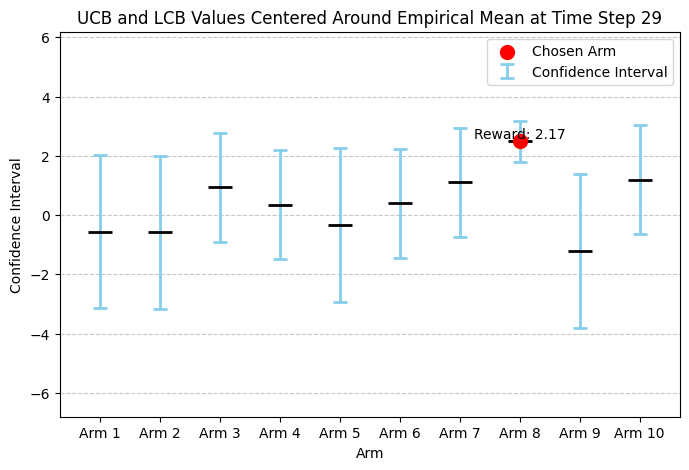

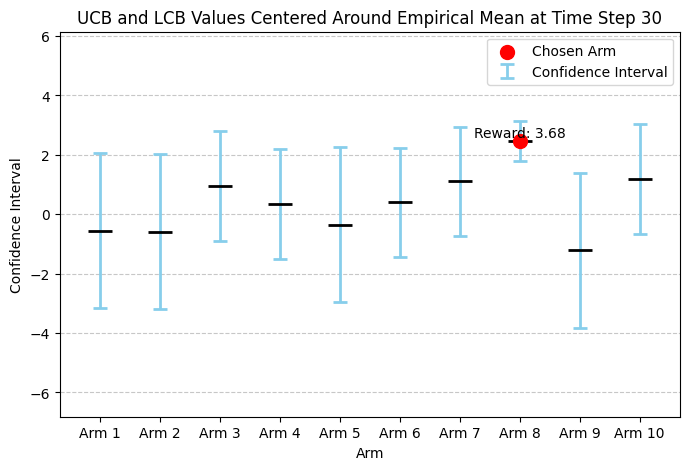

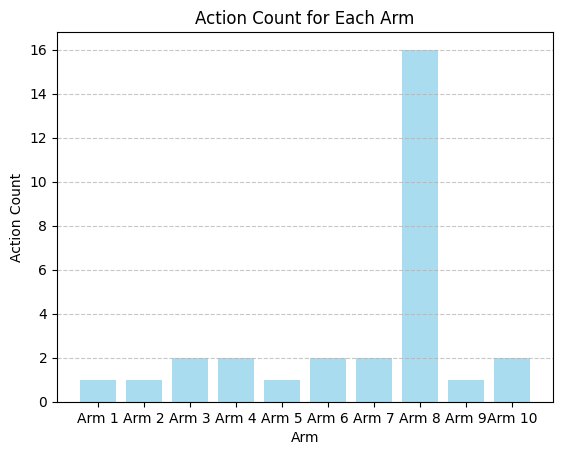

In [17]:

plot_every = 1
number_of_rounds = 30
def plot_ucb_lcb_bar(bandit, total_rounds=20):
    n_arms = bandit.number_of_arms
    counts = np.zeros(n_arms)  # Number of times each arm was chosen
    rewards = np.zeros(n_arms)  # Total reward collected from each arm
    mean_rewards = np.zeros(n_arms)  # Mean reward for each arm
    ucb_values = np.zeros(n_arms)  # Upper Confidence Bound (UCB) values
    lcb_values = np.zeros(n_arms)  # Lower Confidence Bound (LCB) values
    
    for t in range(1, total_rounds + 1):
        for arm in range(n_arms):
            if counts[arm] > 0:
                mean_rewards[arm] = rewards[arm] / counts[arm]
                confidence_interval = np.sqrt((2 * np.log(t)) / counts[arm])
                ucb_values[arm] = mean_rewards[arm] + confidence_interval
                lcb_values[arm] = mean_rewards[arm] - confidence_interval
            else:
                ucb_values[arm] = float('inf') 
                lcb_values[arm] = float('-inf')

        chosen_arm = np.argmax(ucb_values)
        reward = bandit.play(chosen_arm)  
        counts[chosen_arm] += 1
        rewards[chosen_arm] += reward

        ucb_values_for_plot = np.where(np.isinf(ucb_values), 6, ucb_values)
        lcb_values_for_plot = np.where(np.isinf(lcb_values), -6, lcb_values)

        # Plot every plot_every time steps
        if t % plot_every == 0:
            plt.figure(figsize=(8, 5))

            plt.errorbar(range(n_arms), mean_rewards, 
                         yerr=[mean_rewards - lcb_values_for_plot, ucb_values_for_plot - mean_rewards], 
                         fmt='none', ecolor='skyblue', elinewidth=2, capsize=5, capthick=2, label='Confidence Interval')

            for arm in range(n_arms):
                plt.hlines(mean_rewards[arm], arm - 0.2, arm + 0.2, color='black', linewidth=2)

            plt.scatter(chosen_arm, mean_rewards[chosen_arm], color='red', s=100, label='Chosen Arm', zorder=3)

            plt.text(chosen_arm, mean_rewards[chosen_arm], f'Reward: {reward:.2f}', ha='center', va='bottom', fontsize=10, color='black')

            plt.xlabel("Arm")
            plt.ylabel("Confidence Interval")
            plt.title(f"UCB and LCB Values Centered Around Empirical Mean at Time Step {t}")
            plt.xticks(range(n_arms), [f'Arm {i+1}' for i in range(n_arms)])
            plt.ylim(min(min(lcb_values_for_plot)-3, 0), max(ucb_values_for_plot) + 3)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend()
            plt.show()

    plt.bar(range(n_arms), counts, color='skyblue', alpha=0.7)
    plt.xlabel("Arm")
    plt.ylabel("Action Count")
    plt.title("Action Count for Each Arm")
    plt.xticks(range(n_arms), [f'Arm {i+1}' for i in range(n_arms)])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_ucb_lcb_bar(bandit, total_rounds=number_of_rounds)


# Thompson Sampling (optional)

For this part, we need to defined a new multi-armed Bandit class with rewards 0 or 1 (we could use the same class as before but it would need more work so let's keep it simple).

In [18]:
class MultiArmedBanditBernoulli:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.uniform(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]

    def play(self, arm: int) -> float:
        mean = self.means[arm]
        return np.random.binomial(1, mean)
    
bandit_bernoulli = MultiArmedBanditBernoulli(10)
print(bandit_bernoulli.means)


[0.56203165 0.97751671 0.07072187 0.08435824 0.60848655 0.41237456
 0.05540036 0.06244792 0.54703793 0.12018848]


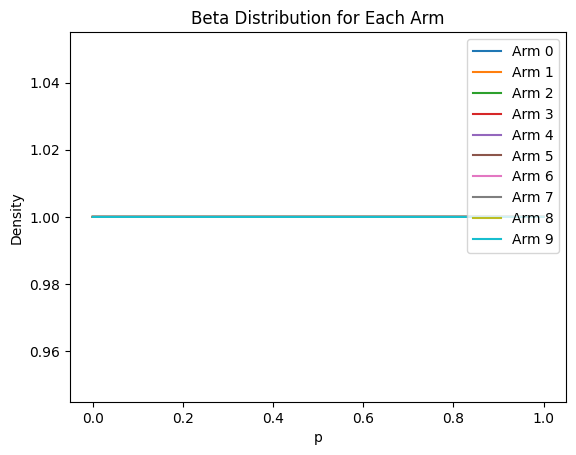

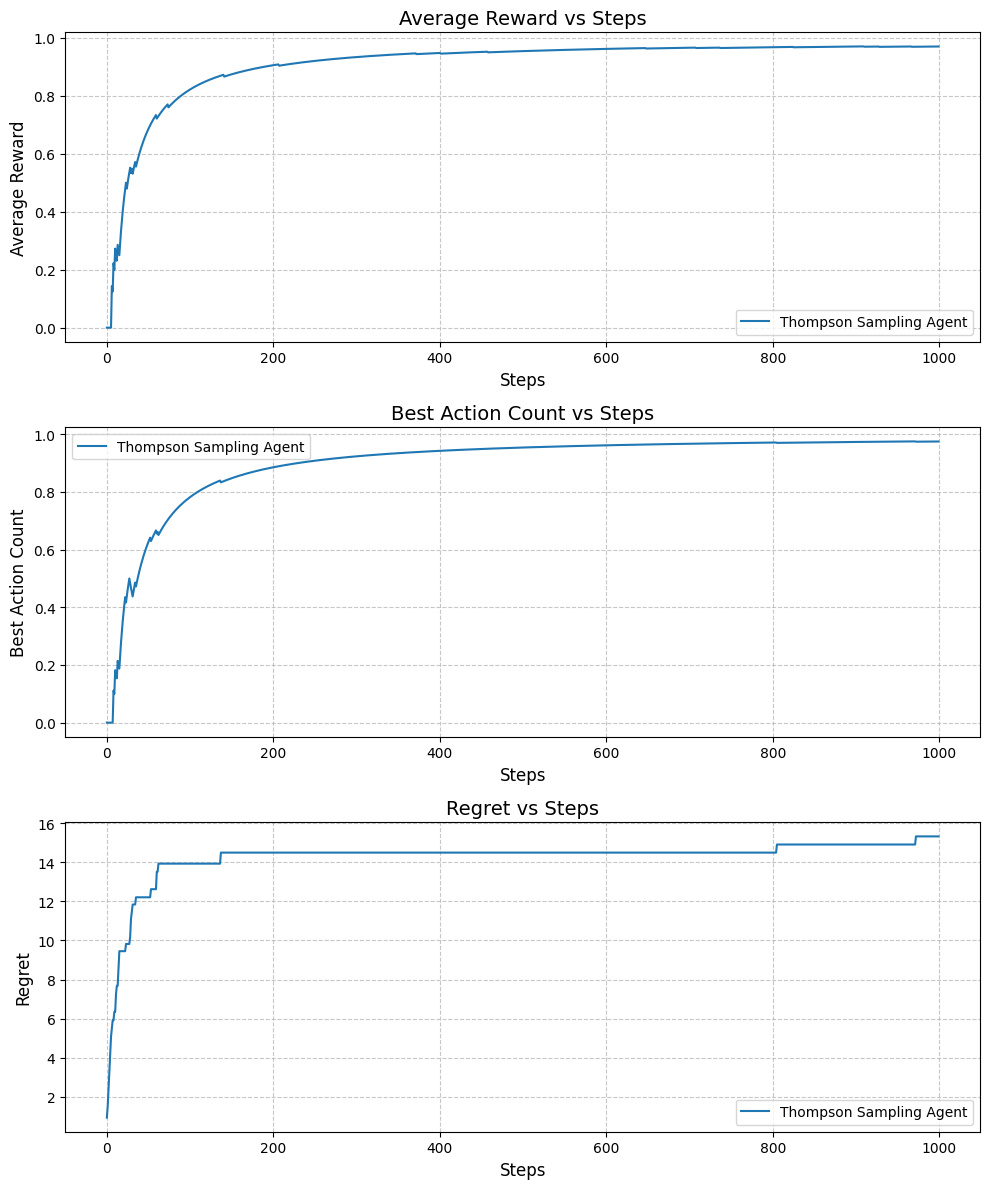

In [22]:
## Thompson Sampling

class ThompsonSampling:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms
        self.alpha = np.ones(self.number_of_arms) # Successes
        self.beta = np.ones(self.number_of_arms) # Failures

    def choose_action(self) -> int:
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.number_of_arms)]
        return np.argmax(samples)

    def update(self, action: int, reward: float) -> None:
        if reward == 1:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def plot_beta_distribution(self, arms= None):
        if arms is None:
            arms = range(self.number_of_arms)
        x = np.linspace(0, 1, 10000)
        for i in arms:
            y = np.exp(np.log(x + 1e-15) * (self.alpha[i] - 1) + np.log(1 - x + 1e-15) * (self.beta[i] - 1))
            plt.plot(x, y, label=f'Arm {i}')
        plt.xlabel('p')
        plt.ylabel('Density')
        plt.title('Beta Distribution for Each Arm')
        plt.legend()
        plt.show()

thompson_sampling_agent = ThompsonSampling(bandit_bernoulli)
thompson_sampling_agent.plot_beta_distribution()
agents = [thompson_sampling_agent]
agent_names = ['Thompson Sampling Agent']
run_and_plot_for_agents(agents, agent_names, bandit_bernoulli, 1000)

[0.56203165 0.97751671 0.07072187 0.08435824 0.60848655 0.41237456
 0.05540036 0.06244792 0.54703793 0.12018848]


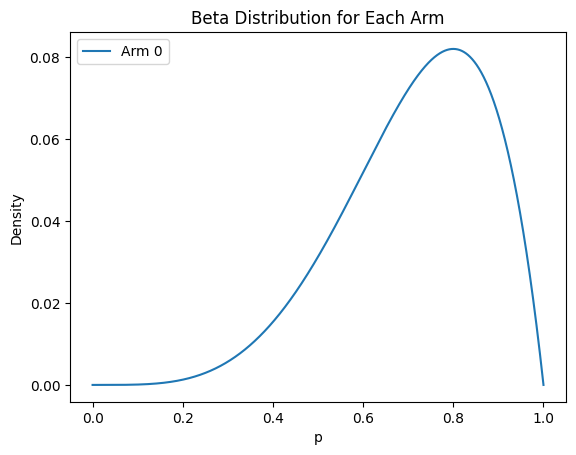

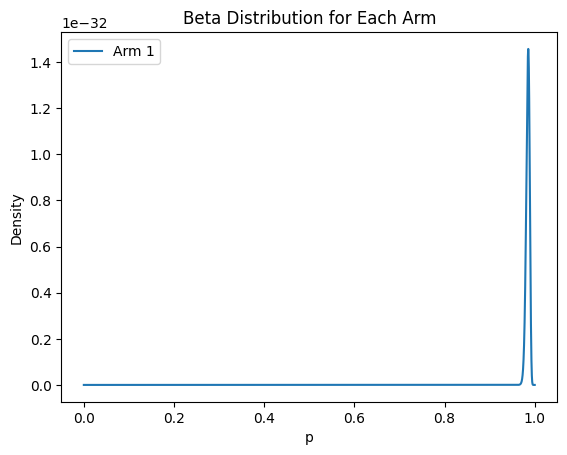

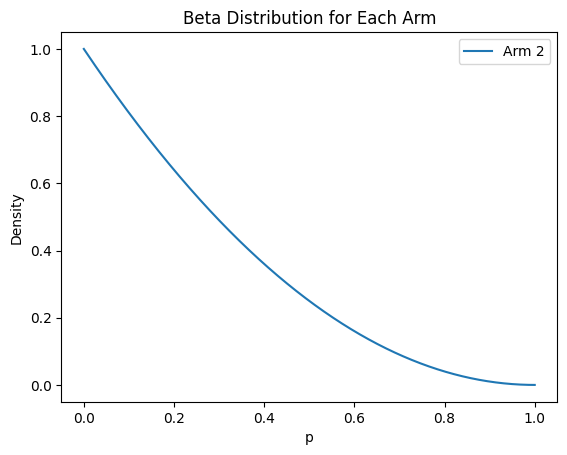

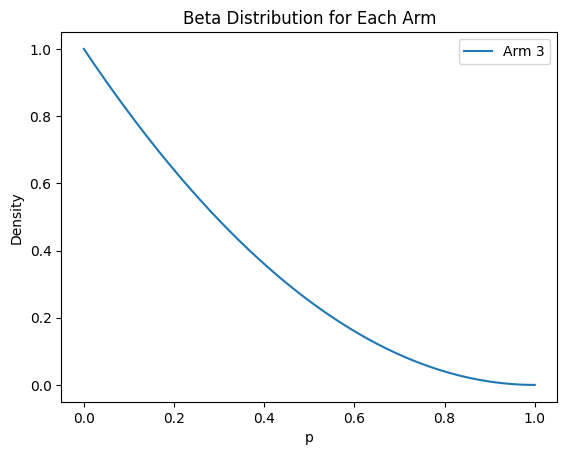

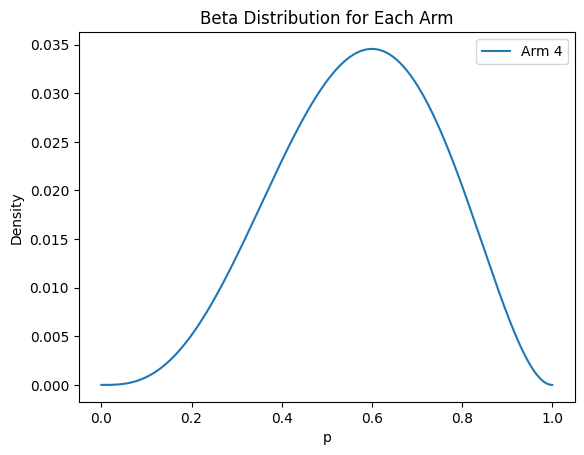

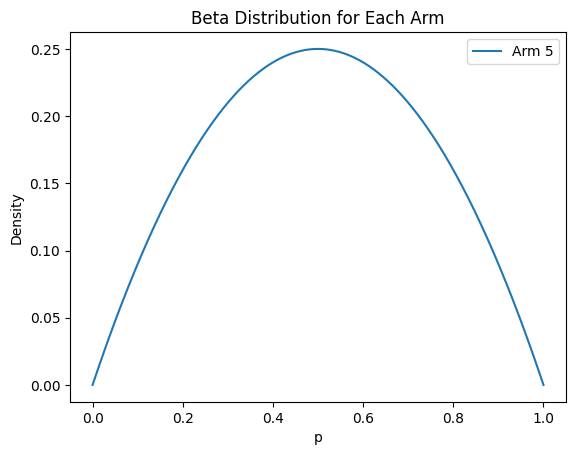

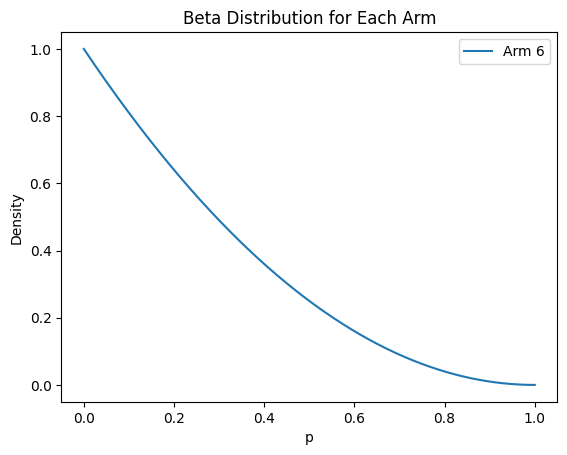

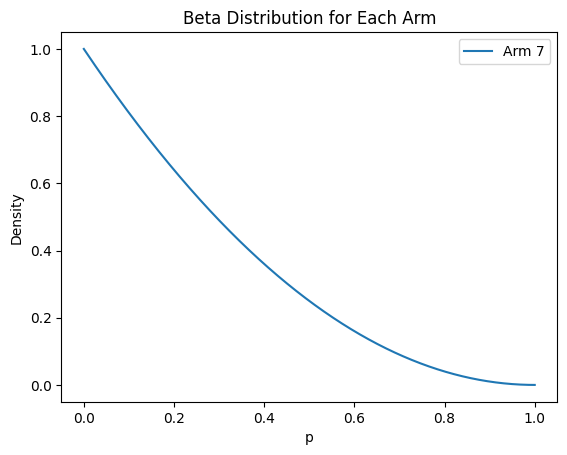

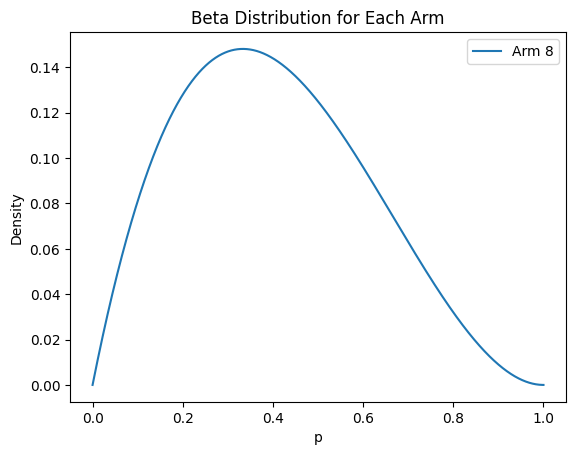

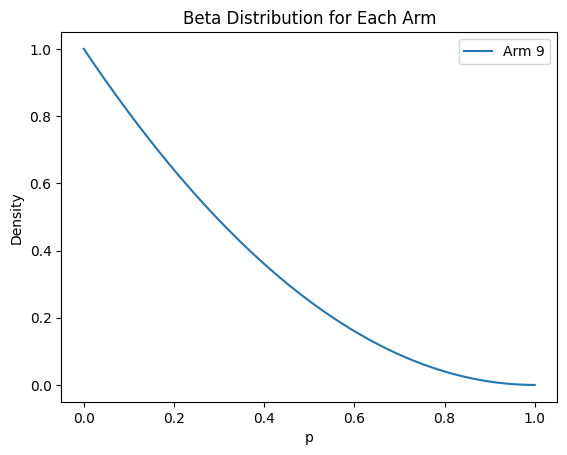

In [23]:
print(bandit_bernoulli.means)
for arm in range(bandit_bernoulli.number_of_arms):
    thompson_sampling_agent.plot_beta_distribution(arms=[arm])